# End-to-end Masked Language Modeling with BERT

**Author:** [Ankur Singh](https://twitter.com/ankur310794)<br>
**Date created:** 2020/09/18<br>
**Last modified:** 2020/09/18<br>
**Description:** Implement a Masked Language Model (MLM) with BERT and fine-tune it on the IMDB Reviews dataset.

https://keras.io/examples/nlp/masked_language_modeling/#create-bert-model-pretraining-model-for-masked-language-modeling

## Introduction

Masked Language Modeling is a fill-in-the-blank task,
where a model uses the context words surrounding a mask token to try to predict what the
masked word should be.

For an input that contains one or more mask tokens,
the model will generate the most likely substitution for each.

Example:

- Input: "I have watched this [MASK] and it was awesome."
- Output: "I have watched this movie and it was awesome."

*Masked language modeling is a **great way to train a language
model in a self-supervised setting**  (without human-annotated labels).
Such a model can then be fine-tuned to accomplish various supervised
NLP tasks.*

This example teaches you how to build a BERT model from scratch,
(두가지 태스크 수행!)
1. train it with the masked language modeling task, **(bert 의 pretraining 방법중 하나)**
2. and then fine-tune this model on a sentiment classification task.



We will use the Keras `TextVectorization` and `MultiHeadAttention` layers
to create a BERT Transformer-Encoder network architecture.

Note: This example should be run with `tf-nightly`.

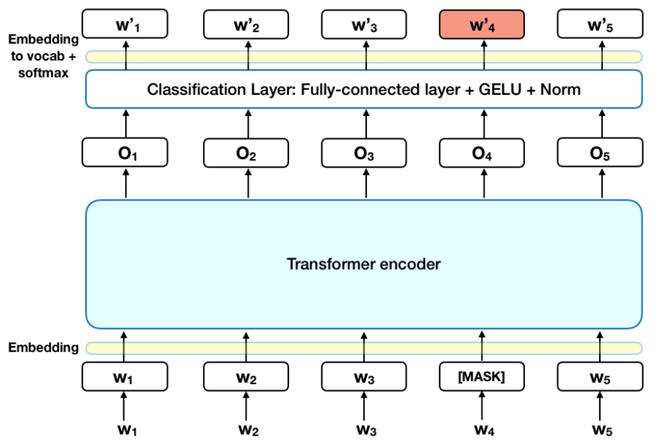

In [1]:
import os
from pathlib import Path
from google.colab import drive
drive.mount("/content/drive")

current_path = Path(os.getcwd())
base_path = current_path / "drive" / "My Drive" /"Colab Notebooks"
os.chdir(base_path)

Mounted at /content/drive


## Setup

Install `tf-nightly` via `pip install tf-nightly`.

In [2]:
!pip install tf-nightly

     |████████████████████████████████| 397.4MB 39kB/s 
     |████████████████████████████████| 1.3MB 50.8MB/s 
     |████████████████████████████████| 10.6MB 41.8MB/s 
     |████████████████████████████████| 14.5MB 121kB/s 
     |████████████████████████████████| 471kB 47.6MB/s 
     |████████████████████████████████| 3.8MB 45.2MB/s 
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Found existing installation: grpcio 1.33.2
    Uninstalling grpcio-1.33

In [3]:
#필요한 library load
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from dataclasses import dataclass
import pandas as pd
import numpy as np
import glob
import re
from pprint import pprint

## Set-up Configuration

In [4]:
# hyper parameter의 효율적인 관리를 위한 configuration 정의
@dataclass
class Config:
    MAX_LEN = 256
    BATCH_SIZE = 32
    LR = 0.001
    VOCAB_SIZE = 30000
    EMBED_DIM = 128
    NUM_HEAD = 8  # used in bert model
    FF_DIM = 128  # used in bert model
    NUM_LAYERS = 1

config = Config()

# 논문에 구현된 bert model hyper parameter

batch size : 256 sequences (256 sequences * 512 tokens = 128,000 tokens/batch) for 1,000,000 steps -> 3.3 billion word corpus의 40 epochs

Adam optimizer

learning rate : 1e-4, β1=0.9, β2=0.999

L2 weight decay of 0.01

learning rate warmup over the first 10,000 steps,linear decay of the learning rate

Dropout prob: 0.1 for all layers

using gelu activation 

*BERT_base - 4 TPUs, BERT_large - 16 TPUs를 사용하여 4일동안 학습*

## Load the data

We will first download the IMDB data and load into a Pandas dataframe.

In [5]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  21.7M      0  0:00:03  0:00:03 --:--:-- 21.7M


In [6]:
#file 에서 부터 text를 한줄 씩 읽어오는 함수
def get_text_list_from_files(files):
    text_list = []
    for name in files:
        with open(name) as f:
            for line in f:
                text_list.append(line)
    return text_list

# text file로 부터 review, sentiment를 가져와 dataframe형태로 저장.
def get_data_from_text_files(folder_name):

    pos_files = glob.glob("aclImdb/" + folder_name + "/pos/*.txt")
    pos_texts = get_text_list_from_files(pos_files)
    neg_files = glob.glob("aclImdb/" + folder_name + "/neg/*.txt")
    neg_texts = get_text_list_from_files(neg_files)
    df = pd.DataFrame(
        {
            "review": pos_texts + neg_texts,
            "sentiment": [0] * len(pos_texts) + [1] * len(neg_texts),
        }
    )
    df = df.sample(len(df)).reset_index(drop=True)
    return df

# train, test data set
train_df = get_data_from_text_files("train")
test_df = get_data_from_text_files("test")

all_data = train_df.append(test_df)

In [7]:
all_data.head(10)

,review,sentiment
0,Paul Verhoeven has one of the strangest oeuvre...,0
1,I've seen this film in avant-premiere at Imagi...,0
2,"If you made a genre flick in the late 80s, you...",1
3,"I though this would be an okay movie, since i ...",1
4,A spaceship returns from Mars; about a couple ...,1
5,"The book is fantastic, this film is not. There...",1
6,Disney might just be on to something here. Fir...,0
7,This movie is excellent. I found it very inter...,0
8,The name Uwe Boll is automatically linked to b...,1
9,My 10/10 rating is merely for the fun factor a...,0


## Dataset preparation

We will use the `TextVectorization` layer to vectorize the text into integer token ids.
It transforms a batch of strings into either
a sequence of token indices (one sample = 1D array of integer token indices, in order)
or a dense representation (one sample = 1D array of float values encoding an unordered set of tokens).

Below, we define 3 preprocessing functions.

1.  The `get_vectorize_layer` function builds the `TextVectorization` layer.
2.  The `encode` function encodes raw text into integer token ids.
3.  The `get_masked_input_and_labels` function will mask input token ids.
It masks 15% of all input tokens in each sequence at random.

In [8]:
# text 전처리 (대소문자, html 함수, 특수문자 처리)
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape("!#$%&'()*+,-./:;<=>?@\^_`{|}~"), ""
    )

# vectorize layer를 만들기 위한 함수
def get_vectorize_layer(texts, vocab_size, max_seq, special_tokens=["[MASK]"]):
    """Build Text vectorization layer

    Args:
      texts (list): List of string i.e input texts
      vocab_size (int): vocab size 
      max_seq (int): Maximum sequence lenght.
      special_tokens (list, optional): List of special tokens. Defaults to ['[MASK]'].

    Returns:
        layers.Layer: Return TextVectorization Keras Layer
    """
    # vectoraze_layer
    vectorize_layer = TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        standardize=custom_standardization, #앞서 만들었던 text 전처리 함수 사용
        output_sequence_length=max_seq,
    )
    #adapt : dataset에 vectorize_layer를 사용하기 위한 함수
    vectorize_layer.adapt(texts)


    # 학습을 위해 vocaburary에 mask token 삽입
    vocab = vectorize_layer.get_vocabulary() #retrieve the computed vocabulary
    vocab = vocab[2 : vocab_size - len(special_tokens)] + ["[mask]"]
    vectorize_layer.set_vocabulary(vocab)
    return vectorize_layer

# all data를 vector화 하기위해 get_vectorize_layer의 input으로 삽입
vectorize_layer = get_vectorize_layer(
    all_data.review.values.tolist(),
    config.VOCAB_SIZE,
    config.MAX_LEN,
    special_tokens=["[mask]"],
)


# MLM(Masked Language Model)을 위해 mask token id를 가져온다 (나중에 학습을 위해)
# mask 된 token 에는 vectorize 된 값을 29999로 넣음 
mask_token_id = vectorize_layer(["[mask]"]).numpy()[0][0] #29999

#vectorize_layer을 이용해 encoding하는 함수
def encode(texts):
    encoded_texts = vectorize_layer(texts)
    return encoded_texts.numpy()

# encoding 된 text데이터에 masking 및 labeling을 수행하는 함수
# input : encoded_texts
# output : encoded_texts_masked, y_labels(=encoded_text), sample_weights
def get_masked_input_and_labels(encoded_texts):
    # 15% BERT masking
    inp_mask = np.random.rand(*encoded_texts.shape) < 0.15
    # special token은 masking 하지 않음
    inp_mask[encoded_texts <= 2] = False
    # 기본적으로 모든 label은 -1로 setting, 무시하라는 의미
    labels = -1 * np.ones(encoded_texts.shape, dtype=int)
    # maked token만 실제 token를 label로 저장
    labels[inp_mask] = encoded_texts[inp_mask]

    # prepare input
    encoded_texts_masked = np.copy(encoded_texts)
    # 90%는 token을 mask로 바꿔준다.
    # eg., my dog is hairy -> my dog is [MASK]
    # 10%는 token을 원래의 단어로 그대로 놔둡니다. 이는 실제 관측된 단어에 대한 표상을 bias해주기 위해 실시함.
    inp_mask_2mask = inp_mask & (np.random.rand(*encoded_texts.shape) < 0.90)
    encoded_texts_masked[
        inp_mask_2mask
    ] = mask_token_id  # mask token is the last in the dict

    # Set 10% to a random token
    # inp_mask_2mask 중 1/9(전체의 10%)는 random word 로 바꿔준다.
    # my dog is hariy -> my dog is apple
    inp_mask_2random = inp_mask_2mask & (np.random.rand(*encoded_texts.shape) < 1 / 9)
    encoded_texts_masked[inp_mask_2random] = np.random.randint(
        3, mask_token_id, inp_mask_2random.sum()
    )

    # prepare sample_weights (.fit() method를 통과하기 위함)
    sample_weights = np.ones(labels.shape)
    sample_weights[labels == -1] = 0 #masking 되지 않은 vocab

    # y label은 encoded text와 같아야 한다. (i.e input tokens)
    y_labels = np.copy(encoded_texts)

    return encoded_texts_masked, y_labels, sample_weights


# training : 25000 examples
x_train = encode(train_df.review.values)  # encode reviews with vectorizer
y_train = train_df.sentiment.values # positive/negative
train_classifier_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1000) #pos & neg가 적절히 섞이도록 suffle
    .batch(config.BATCH_SIZE)
)

# testing: 25000 examples
x_test = encode(test_df.review.values)
y_test = test_df.sentiment.values 
test_classifier_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(
    config.BATCH_SIZE
)

# Build dataset for end to end model input (will be used at the end)
test_raw_classifier_ds = tf.data.Dataset.from_tensor_slices(
    (test_df.review.values, y_test)
).batch(config.BATCH_SIZE)

# masked language model을 위한 data
x_all_review = encode(all_data.review.values)
x_masked_train, y_masked_labels, sample_weights = get_masked_input_and_labels(
    x_all_review
)

mlm_ds = tf.data.Dataset.from_tensor_slices(
    (x_masked_train, y_masked_labels, sample_weights)
)
mlm_ds = mlm_ds.shuffle(1000).batch(config.BATCH_SIZE)

#### data preperation####
#(task 1) masked language model : mlm_ds
#(task 2) sentiment classificatoin : train_classifier_ds,test_classifier_ds,
# end to end model : test_raw_classifier_ds

## Create BERT model (Pretraining Model) for masked language modeling

We will create a BERT-like pretraining model architecture
using the `MultiHeadAttention` layer.
It will take token ids as inputs (including masked tokens)
and it will predict the correct ids for the masked input tokens.

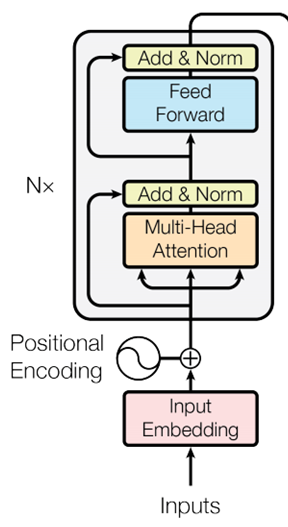

In [9]:
#BERT-like pretraining model

def bert_module(query, key, value, i):
    # Multi headed self-attention
    # multibhead attention output 과 feed forward output의 결과를 합한 seqeucne output을 반환한다.
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name="encoder_{}/multiheadattention".format(i),
    )(query, key, value)
    #dropout
    attention_output = layers.Dropout(0.1, name="encoder_{}/att_dropout".format(i))(
        attention_output
    )
    #normalization
    attention_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}/att_layernormalization".format(i)
    )(query + attention_output)

    # Feed-forward layer
    ffn = keras.Sequential(
        [
            layers.Dense(config.FF_DIM, activation="relu"),
            layers.Dense(config.EMBED_DIM),
        ],
        name="encoder_{}/ffn".format(i),
    )
    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1, name="encoder_{}/ffn_dropout".format(i))(
        ffn_output
    )
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}/ffn_layernormalization".format(i)
    )(attention_output + ffn_output)
    return sequence_output

# positional encdoing을 하기 위한 함수
# transformer의 positional encoding과 같은 맥락
def get_pos_encoding_matrix(max_len, d_emb):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
            if pos != 0
            else np.zeros(d_emb)
            for pos in range(max_len)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc

# loss function 정의 : SparseCategoricalCrossentropy
loss_fn = keras.losses.SparseCategoricalCrossentropy(
    reduction=tf.keras.losses.Reduction.NONE
)
loss_tracker = tf.keras.metrics.Mean(name="loss")

#Model gradient 계산 class, keras Model 대신 사용
class MaskedLanguageModel(tf.keras.Model):
    def train_step(self, inputs):
        if len(inputs) == 3:
            features, labels, sample_weight = inputs
        else:
            features, labels = inputs
            sample_weight = None

        with tf.GradientTape() as tape:
            predictions = self(features, training=True)
            loss = loss_fn(labels, predictions, sample_weight=sample_weight)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics
        loss_tracker.update_state(loss, sample_weight=sample_weight)

        # Return a dict mapping metric names to current value
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [loss_tracker]

# BERT
def create_masked_language_bert_model():
    # input
    inputs = layers.Input((config.MAX_LEN,), dtype=tf.int64)
    
    # encoder(embedding)
    word_embeddings = layers.Embedding(
        config.VOCAB_SIZE, config.EMBED_DIM, name="word_embedding"
    )(inputs)
    position_embeddings = layers.Embedding(
        input_dim=config.MAX_LEN,
        output_dim=config.EMBED_DIM,
        weights=[get_pos_encoding_matrix(config.MAX_LEN, config.EMBED_DIM)],
        name="position_embedding",
    )(tf.range(start=0, limit=config.MAX_LEN, delta=1))
    embeddings = word_embeddings + position_embeddings # transformer 와 같은 형태, word enbedding + position embedding으로 단어,맥락 정보 모두 보존
    encoder_output = embeddings
    
    # NUM_LAYERS만큼 bert module(transformer의 encoder) 쌓기
    # NUM_LAYERS = 1
    # BERT base : NUM LAYER = 12
    # BERT large : NUM LAYER = 16 ==> 많은 양의 resource 필요
    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module(encoder_output, encoder_output, encoder_output, i)

    # output
    mlm_output = layers.Dense(config.VOCAB_SIZE, name="mlm_cls", activation="softmax")(
        encoder_output
    )
    # keras package Model 대신 앞서 정의한 MaskedLanguageModel class 사용
    mlm_model = MaskedLanguageModel(inputs, mlm_output, name="masked_bert_model")

    optimizer = keras.optimizers.Adam(learning_rate=config.LR)
    mlm_model.compile(optimizer=optimizer)
    return mlm_model


id2token = dict(enumerate(vectorize_layer.get_vocabulary()))
token2id = {y: x for x, y in id2token.items()}

# call back class
class MaskedTextGenerator(keras.callbacks.Callback):
    def __init__(self, sample_tokens, top_k=5):
        self.sample_tokens = sample_tokens
        self.k = top_k

    def decode(self, tokens):
        return " ".join([id2token[t] for t in tokens if t != 0])

    def convert_ids_to_tokens(self, id):
        return id2token[id]

    def on_epoch_end(self, epoch, logs=None):
        prediction = self.model.predict(self.sample_tokens)

        masked_index = np.where(self.sample_tokens == mask_token_id)
        masked_index = masked_index[1]
        mask_prediction = prediction[0][masked_index]

        top_indices = mask_prediction[0].argsort()[-self.k :][::-1]
        values = mask_prediction[0][top_indices]

        for i in range(len(top_indices)):
            p = top_indices[i]
            v = values[i]
            tokens = np.copy(sample_tokens[0])
            tokens[masked_index[0]] = p
            result = {
                "input_text": self.decode(sample_tokens[0].numpy()),
                "prediction": self.decode(tokens),
                "probability": v,
                "predicted mask token": self.convert_ids_to_tokens(p),
            }
            pprint(result)


sample_tokens = vectorize_layer(["I have watched this [mask] and it was awesome"])
generator_callback = MaskedTextGenerator(sample_tokens.numpy())

bert_masked_model = create_masked_language_bert_model()

bert_masked_model.summary()

Model: "masked_bert_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, 256, 128)     3840000     input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.add (TFOpLambd (None, 256, 128)     0           word_embedding[0][0]             
__________________________________________________________________________________________________
encoder_0/multiheadattention (M (None, 256, 128)     66048       tf.__operators__.add[0][0]       
                                                                 tf.__operators__.

## Train and Save

In [ ]:
bert_masked_model.fit(mlm_ds, epochs=5, callbacks=[generator_callback])
bert_masked_model.save("./bert_mlm_imdb.h5")

Epoch 1/5
1563/1563 [==============================] - 9690s 6s/step - loss: 6.9929
{'input_text': 'i have watched this [mask] and it was awesome',
 'predicted mask token': 'this',
 'prediction': 'i have watched this this and it was awesome',
 'probability': 0.05787566}
{'input_text': 'i have watched this [mask] and it was awesome',
 'predicted mask token': 'i',
 'prediction': 'i have watched this i and it was awesome',
 'probability': 0.04457543}
{'input_text': 'i have watched this [mask] and it was awesome',
 'predicted mask token': 'movie',
 'prediction': 'i have watched this movie and it was awesome',
 'probability': 0.036321603}
{'input_text': 'i have watched this [mask] and it was awesome',
 'predicted mask token': 'to',
 'prediction': 'i have watched this to and it was awesome',
 'probability': 0.032481406}
{'input_text': 'i have watched this [mask] and it was awesome',
 'predicted mask token': 'a',
 'prediction': 'i have watched this a and it was awesome',
 'probability': 0.030

## Fine-tune a sentiment classification model

We will fine-tune our self-supervised model on a downstream task of sentiment classification.
To do this, let's create a classifier by adding a pooling layer and a `Dense` layer on top of the
pretrained BERT features.

In [ ]:
# 앞서 pretraining된 bert 함수 load
# 보통은 google에서 pretraining 된 다양한 모델을 불러와서 finetuning ==> 좋은 성능!

mlm_model = keras.models.load_model(
    "bert_mlm_imdb.h5", custom_objects={"MaskedLanguageModel": MaskedLanguageModel}
)
pretrained_bert_model = tf.keras.Model(
    mlm_model.input, mlm_model.get_layer("encoder_0/ffn_layernormalization").output
) 
# input과 bert module의 "encoder_0/ffn_layernormalization" layer 반환

# Freeze it
pretrained_bert_model.trainable = False

# sentiment classification task를 위한 함수
def create_classifier_bert_model():
    inputs = layers.Input((config.MAX_LEN,), dtype=tf.int64)
    sequence_output = pretrained_bert_model(inputs) # pretrained model : trainable = False (freeze)
    #weight update
    pooled_output = layers.GlobalMaxPooling1D()(sequence_output)
    hidden_layer = layers.Dense(64, activation="relu")(pooled_output)
    outputs = layers.Dense(1, activation="sigmoid")(hidden_layer)
    classifer_model = keras.Model(inputs, outputs, name="classification")
    optimizer = keras.optimizers.Adam()
    classifer_model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return classifer_model


classifer_model = create_classifier_bert_model()
classifer_model.summary()

# Train the classifier with frozen BERT stage
classifer_model.fit(
    train_classifier_ds,
    epochs=5,
    validation_data=test_classifier_ds,
)

# fine tunning을 위해 BERT model unfreeze
pretrained_bert_model.trainable = True
optimizer = keras.optimizers.Adam()
classifer_model.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)
classifer_model.fit(
    train_classifier_ds,
    epochs=5,
    validation_data=test_classifier_ds,
)

## Create an end-to-end model and evaluate it

When you want to deploy a model, it's best if it already includes its preprocessing
pipeline, so that you don't have to reimplement the preprocessing logic in your
production environment. Let's create an end-to-end model that incorporates
the `TextVectorization` layer, and let's evaluate. Our model will accept raw strings
as input.

In [ ]:
# end to end 모델
def get_end_to_end(model):
    inputs_string = keras.Input(shape=(1,), dtype="string")
    indices = vectorize_layer(inputs_string)
    outputs = model(indices)
    end_to_end_model = keras.Model(inputs_string, outputs, name="end_to_end_model")
    optimizer = keras.optimizers.Adam(learning_rate=config.LR)
    end_to_end_model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return end_to_end_model


end_to_end_classification_model = get_end_to_end(classifer_model)
end_to_end_classification_model.evaluate(test_raw_classifier_ds)